In [1]:
from lbmpy.session import *
from lbmpy.boundaries.boundaries_in_kernel import update_rule_with_push_boundaries
from lbmpy.macroscopic_value_kernels import macroscopic_values_getter, macroscopic_values_setter
from collections import OrderedDict
from time import perf_counter

# Version 1: compile-in boundaries

In [2]:
domain_size = (32, 32, 32)
relaxation_rate = 1.8
time_steps = 100
lid_velocity = 0.05

In [3]:
dh = create_data_handling(domain_size, default_target='cpu')
pdfs = dh.add_array('pdfs', values_per_cell=19)
u = dh.add_array('u', values_per_cell=len(domain_size))

In [4]:
boundaries = OrderedDict((
    ((0, 1, 0), UBB([lid_velocity, 0, 0])),    
    ((1, 0, 0), NoSlip()),
    ((-1, 0, 0), NoSlip()),
    ((0, -1, 0), NoSlip()),
    ((0, 0, 1), NoSlip()),
    ((0, 0, -1), NoSlip()),
))
opt = {'symbolic_field': pdfs, 'cse_global': False, 'cse_pdfs': True}
cr_even = create_lb_collision_rule(stencil="D3Q19", relaxation_rate=relaxation_rate, compressible=False, optimization=opt)
cr_odd = create_lb_collision_rule(stencil="D3Q19", relaxation_rate=relaxation_rate, compressible=False,  optimization=opt)
update_rule_aa_even = update_rule_with_push_boundaries(cr_even, pdfs, boundaries, AAEvenTimeStepAccessor, AAOddTimeStepAccessor.read)
update_rule_aa_odd = update_rule_with_push_boundaries(cr_odd, pdfs, boundaries, AAOddTimeStepAccessor, AAEvenTimeStepAccessor.read)

getter_assignments = macroscopic_values_getter(update_rule_aa_even.method, velocity=u.center_vector,
                                               pdfs=pdfs.center_vector, density=None)

getter_kernel = ps.create_kernel(getter_assignments, target=dh.default_target).compile()
even_kernel = ps.create_kernel(update_rule_aa_even, target=dh.default_target, ghost_layers=1).compile()
odd_kernel = ps.create_kernel(update_rule_aa_odd, target=dh.default_target, ghost_layers=1).compile()

In [5]:
def init():
    dh.fill(pdfs.name, 0, ghost_layers=True)

def aa_time_loop(steps=100):
    assert steps % 2 == 0, "Works only for an even number of time steps"
    dh.all_to_gpu()
    for i in range(steps // 2):
        dh.run_kernel(odd_kernel)
        dh.run_kernel(even_kernel)
    dh.run_kernel(getter_kernel)        
    dh.all_to_cpu()

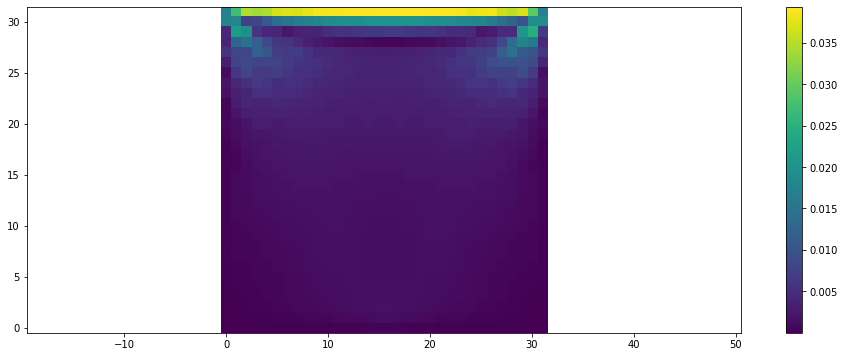

In [6]:
init()
aa_time_loop(time_steps)
vel_version1 = dh.gather_array(u.name, ghost_layers=False).copy()
plt.vector_field_magnitude(vel_version1[:, :, domain_size[2]//2, :])
plt.colorbar();

# Version 2: Normal boundary handling

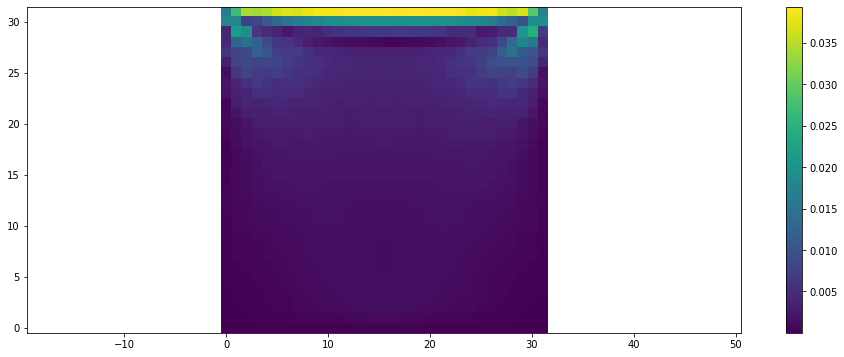

In [7]:
ldc = create_lid_driven_cavity(domain_size, relaxation_rate=relaxation_rate, lid_velocity=lid_velocity)
ldc.run(time_steps)
vel_version2 = ldc.velocity[:, :, :, :]

plt.vector_field_magnitude(vel_version2[:, :, domain_size[2]//2, :])
plt.colorbar();